# Overall introduction to solutions

Requirements: 
- Keep data and ipynb in same folder 
- Use environment settings from the file xxxx

# check raster output and shapefile output (outputs in general)
# update what is included in the final folder
# do the last assignment part 

In [1]:
# import relevant modules
## relevant for raster: 
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import collections

## relevant for spatial autocorrelation: 
import pandas as pd 
import geopandas as gpd 
from pysal.lib import weights
from pysal.explore import esda

## relevant for both raster and spatial autocorrelation: 
import os

/Users/idarei/anaconda3/envs/Assignment/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# Raster analysis 

### 1. Write a function that plots the projected total and urban population from 2010 to 2100 for a selected country as a line chart. The attached countries.tif contains the country ID for each cell; this list shows which ID is which country.


In [2]:
# print countries with country IDs to get to know data:
country_tif = rasterio.open(os.getcwd()+"/inputs/countries.tif")
print("Country is", country_tif.width, "x",country_tif.height,"pixels big")
print("It is in the following CRS:",country_tif.crs)
print("It covers the following extent:",country_tif.bounds)

Country is 2880 x 1117 pixels big
It is in the following CRS: EPSG:4326
It covers the following extent: BoundingBox(left=-180.0, bottom=-55.875, right=180.0, top=83.75)


In [3]:
# print example of a population dataset to check that the population datasets have the same distribution: 
pop_ex_tif = rasterio.open(os.getcwd()+"/inputs/popdynamics-pop-projection-ssp-2010-2100-ssp4-geotiff/SSP4/Total/GeoTIFF/ssp4_2080.tif")
print("Population example is", pop_ex_tif.width, "x",pop_ex_tif.height,"pixels big")
print("It is in the following CRS:",pop_ex_tif.crs)
print("It covers the following extent:",pop_ex_tif.bounds) 

Population example is 2880 x 1117 pixels big
It is in the following CRS: EPSG:4326
It covers the following extent: BoundingBox(left=-180.0, bottom=-55.875000000084995, right=180.0, top=83.749999999915)


In [4]:
# print unique countries (this list shows the countries by name: https://en.wikipedia.org/wiki/ISO_3166-1_numeric): 
countries = country_tif.read(1)
countries = countries.astype(int)
np.unique(countries)

array([-99,   4,   8,  12,  16,  24,  28,  31,  32,  36,  40,  44,  48,
        50,  51,  52,  56,  60,  64,  68,  70,  72,  76,  84,  86,  90,
        92,  96, 100, 104, 108, 112, 116, 120, 124, 132, 136, 140, 144,
       148, 152, 156, 158, 170, 174, 178, 180, 184, 188, 191, 192, 196,
       203, 204, 208, 212, 214, 218, 222, 226, 231, 232, 233, 234, 238,
       239, 242, 246, 248, 250, 258, 260, 262, 266, 268, 270, 275, 276,
       288, 292, 296, 300, 304, 308, 316, 320, 324, 328, 332, 334, 336,
       340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380, 384, 388,
       392, 398, 400, 404, 408, 410, 414, 417, 418, 422, 426, 428, 430,
       434, 438, 440, 442, 446, 450, 454, 458, 462, 466, 470, 478, 480,
       484, 492, 496, 498, 499, 500, 504, 508, 512, 516, 520, 524, 528,
       531, 533, 534, 540, 548, 554, 558, 562, 566, 570, 574, 580, 581,
       583, 584, 585, 586, 591, 598, 600, 604, 608, 612, 616, 620, 624,
       626, 630, 634, 642, 643, 646, 652, 654, 659, 660, 662, 66

In [5]:
# create a country code dictionary with country codes as int keys and country names as values and print it for country reference
countrycodedict = {}
cc = open(os.getcwd()+"/inputs/countrycodes.csv","r")
for line in cc.readlines():
    linelist = line.split(";")
    if ord(linelist[0][0]) == 65279: 
        countrycodedict[int(linelist[0][1])] = linelist[1]    
    else: 
        countrycodedict[int(linelist[0])] = linelist[1]
countrycodedict

{4: 'Afghanistan\n',
 8: 'Albania\n',
 10: 'Antarctica\n',
 12: 'Algeria\n',
 16: 'American Samoa\n',
 20: 'Andorra\n',
 24: 'Angola\n',
 28: 'Antigua and Barbuda\n',
 31: 'Azerbaijan\n',
 32: 'Argentina\n',
 36: 'Australia\n',
 40: 'Austria\n',
 44: 'Bahamas\n',
 48: 'Bahrain\n',
 50: 'Bangladesh\n',
 51: 'Armenia\n',
 52: 'Barbados\n',
 56: 'Belgium\n',
 60: 'Bermuda\n',
 64: 'Bhutan\n',
 68: 'Bolivia (Plurinational State of)\n',
 70: 'Bosnia and Herzegovina\n',
 72: 'Botswana\n',
 74: 'Bouvet Island\n',
 76: 'Brazil\n',
 84: 'Belize\n',
 86: 'British Indian Ocean Territory\n',
 90: 'Solomon Islands\n',
 92: 'Virgin Islands (British)\n',
 96: 'Brunei Darussalam\n',
 100: 'Bulgaria\n',
 104: 'Myanmar\n',
 108: 'Burundi\n',
 112: 'Belarus\n',
 116: 'Cambodia\n',
 120: 'Cameroon\n',
 124: 'Canada\n',
 132: 'Cabo Verde\n',
 136: 'Cayman Islands\n',
 140: 'Central African Republic\n',
 144: 'Sri Lanka\n',
 148: 'Chad\n',
 152: 'Chile\n',
 156: 'China\n',
 158: 'Taiwan, Province of China\n

In [8]:
# SOLUTION: Function to plot linecharts of the population estimation for a specific country over time:
### Inputs are: 1) countries: a numpy array with the country tif file values 2) poptype: a string which can be either 
### "Total" (default), "Urban", or "Rural" 3) countrycodedict: a dict with countrycode as int key and country name 
### as string value 4) chosenCountry: an integer value existing in the countrycodedict
def printLineChartForCountry(countries, countrycodedict, chosenCountry, poptype="Total"):
    popdict = {}
    try: 
        if poptype == "Total":
            subfilepath = "/inputs/popdynamics-pop-projection-ssp-2010-2100-ssp4-geotiff/SSP4/Total/GeoTIFF/"
        elif poptype == "Urban":
            subfilepath = "/inputs/popdynamics-pop-projection-ssp-2010-2100-ssp4-geotiff/SSP4/Urban/GeoTIFF/"
        elif poptype == "Rural":
            subfilepath = "/inputs/popdynamics-pop-projection-ssp-2010-2100-ssp4-geotiff/SSP4/Urban/GeoTIFF/"
        else: 
            print("wwww try ", poptype)
    except Exception as err: 
        print("poptype or subfilepath does not exist: ", err)
    # get population counts for all pop-tif-files representing different years: 
    for file in os.listdir(os.getcwd()+subfilepath): 
        if file[-4:] == ".tif":
            year = int(file[-8:-4])
            pop_tif = rasterio.open(os.getcwd()+subfilepath+file)
            popu = pop_tif.read(1)
            # to describe whether each raster cell belongs to the chosen country: 
            incountry = (countries == chosenCountry)
            # zonal sum pop statistics for chosen country: 
            pop_count = round(((np.sum(popu[incountry]))/1000000.), 4)
            popdict[year] = pop_count
    popdictorder = collections.OrderedDict(sorted(popdict.items()))
    print (popdictorder)
    countryname = countrycodedict.get(chosenCountry)
    plt.plot(popdictorder.keys(), popdictorder.values())
    plt.title("{} population prediction for {}".format(poptype, countryname), fontweight="bold")
    plt.xlabel("Year")
    plt.ylabel("Population in millions (10**6)")
    plt.show()
    plt.close()


OrderedDict([(2010, 5.6664), (2020, 5.878), (2030, 6.0362), (2040, 6.1251), (2050, 6.1485), (2060, 6.1178), (2070, 6.0194), (2080, 5.8498), (2090, 5.6018), (2100, 5.2883)])


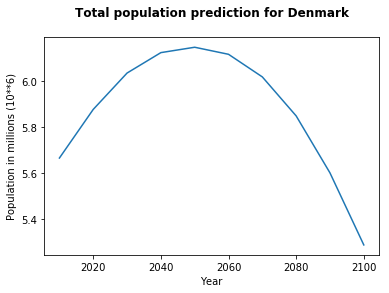

OrderedDict([(2010, 4.909), (2020, 5.2118), (2030, 5.4332), (2040, 5.5713), (2050, 5.6356), (2060, 5.6397), (2070, 5.5737), (2080, 5.4359), (2090, 5.22), (2100, 4.9392)])


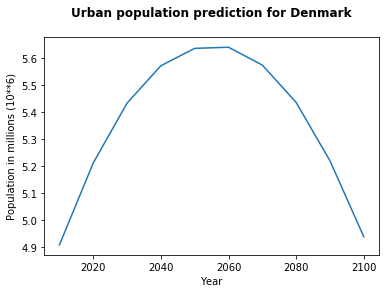

OrderedDict([(2010, 25964.4136), (2020, 25978.577), (2030, 25986.7601), (2040, 25988.5022), (2050, 25984.0704), (2060, 25974.0239), (2070, 25959.5812), (2080, 25942.0808), (2090, 25923.2835), (2100, 25904.7157)])


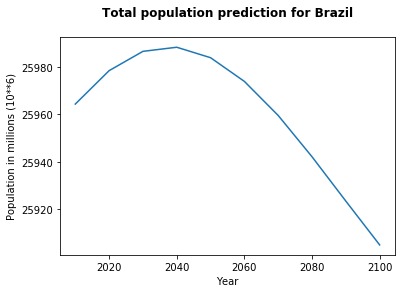

OrderedDict([(2010, 25938.1969), (2020, 25954.9987), (2030, 25965.5472), (2040, 25969.5278), (2050, 25967.2667), (2060, 25959.3401), (2070, 25946.9428), (2080, 25931.3486), (2090, 25914.2607), (2100, 25897.1961)])


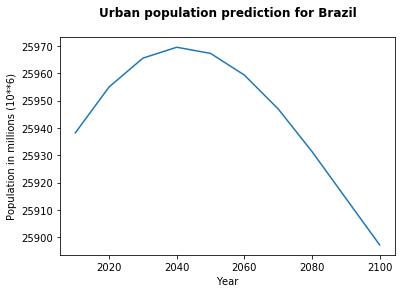

In [10]:
# Calling the function to plot total and urban population projections for Denmark and Brazil: 
popdictDK = printLineChartForCountry(countries, countrycodedict, 208, "Total")
popdictDK_Urban = printLineChartForCountry(countries, countrycodedict, 208, "Urban")
popdictBrazil = printLineChartForCountry(countries, countrycodedict, 76, "Total")
popdictBrazil_Urban = printLineChartForCountry(countries, countrycodedict, 76, "Urban")

### 2. Generate a global raster that shows only the cells that are projected to lose population, and indicates how much the population in those cells is projected to decline between 2010 and 2100.

In [11]:
# Function to create new subfolder if it does not already exist: 
def newSubfolder(outputfoldername):
    if not os.path.exists(os.getcwd()+"/"+outputfoldername):
        print (os.getcwd()+"/"+outputfoldername, " is created")
        os.makedirs(os.getcwd()+"/"+outputfoldername)
    else: 
        print (os.getcwd()+"/"+outputfoldername, " is not created")

# Function to create a new raster from numpyarray based on aother existing raster profile 
# - or to be used to compress existing raster:
def compress(inputfile, outputfile, layer, compression, datatype): 
    with rasterio.Env():
        # Write an array as a raster band to a new 8-bit file. For
        # the new file's profile, we start with the profile of the source
        profile = inputfile.profile
        # And then change the band count to 1, set the
        # dtype to uint8, and specify LZW compression.
        profile.update(
            dtype=datatype,
            count=1,
            compress=compression)
        with rasterio.open(outputfile, 'w', **profile) as dst:
            dst.write(layer.astype(datatype), 1)

In [12]:
# SOLUTION: Function to generate a population decline raster - only showing cells with population that decline - between 
# year popyearFirst and year popyearLast
### Inputs are: 1) popyearFirst: base year to compare potential decline with 2) popyearLast: year to evaluate decline  
### 3) poptype: population type with three options "Total" (default), "Urban", or "Rural".
def createPopulationDeclineRaster(popyearFirst, popyearLast, poptype="Total"):  
    #countries, countrycodedict, chosenCountry):
    #popdict = {}
    try: 
        if poptype == "Total":
            subfilepath = "/inputs/popdynamics-pop-projection-ssp-2010-2100-ssp4-geotiff/SSP4/Total/GeoTIFF/"
        elif poptype == "Urban":
            subfilepath = "/inputs/popdynamics-pop-projection-ssp-2010-2100-ssp4-geotiff/SSP4/Urban/GeoTIFF/"
        elif poptype == "Rural":
            subfilepath = "/inputs/popdynamics-pop-projection-ssp-2010-2100-ssp4-geotiff/SSP4/Urban/GeoTIFF/"
    except Exception as err: 
        print("poptype or subfilepath does not exist: ", err)
    # get population counts for all pop-tif-files representing different years: 
    for file in os.listdir(os.getcwd()+subfilepath): 
        if file[-4:] == ".tif" and int(file[-8:-4]) == popyearFirst:
            raster_first_tif = rasterio.open(os.getcwd()+subfilepath+file)
            raster_first = raster_first_tif.read(1)
        if file[-4:] == ".tif" and int(file[-8:-4]) == popyearLast:
            raster_last_tif = rasterio.open(os.getcwd()+subfilepath+file)
            raster_last = raster_last_tif.read(1)
    raster_dif = raster_last - raster_first
    raster_dif = raster_dif.astype(float)
    raster_dif[raster_dif >= 0] = np.nan
    outputfoldername = "outputs"
    newSubfolder(outputfoldername)
    compress(raster_first_tif, os.getcwd()+"/"+outputfoldername+"/pop_decline.tif", raster_dif, None, rasterio.float32)
    return raster_dif


In [13]:
# Calling the function to get a population decline raster between year 2010 and 2100 for the total population: 
raster_dif = createPopulationDeclineRaster(2010, 2100, poptype="Total")

/Users/idarei/Documents/9Geopython/final_exercise/outputs  is not created


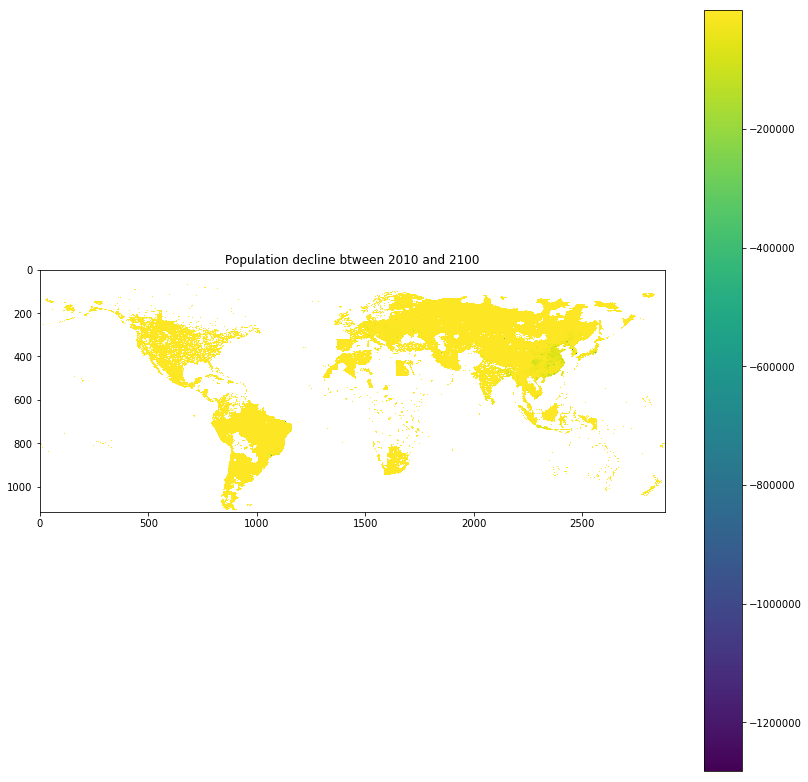

In [14]:
# Plotting the resulting global population decline raster between year 2010 and 2100 
# (the lower number, the higher decline): 
plt.figure(figsize=(14, 14))
plt.title('Population decline btween 2010 and 2100')
imgplot = plt.imshow(raster_dif)
plt.colorbar()

# Spatial autocorrelation analysis 

### 1. Download a shapefile of the world from naturalearthdata.com and perform a left join with the attached under5mortality.csv, which contains child mortality rates for each country in the world. The join should be done on the ISO_A3 column in the shapefile and the ISO column in the CSV, respectively.

In [15]:
# Read shapefile naturalearthdata (worlddata), print columns, check the data type of the column 'ISO_A3', and print shape:
naturalearthdata = os.getcwd()+"/inputs/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp" 
worlddata = gpd.read_file(naturalearthdata)
print(worlddata.columns)
print(worlddata['ISO_A3'].dtypes)
print(worlddata.shape)

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT',
       'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG',
       'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN',
       'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT',
       'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13',
       'POP_EST', 'POP_RANK', 'GDP_MD_EST', 'POP_YEAR', 'LASTCENSUS',
       'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'WIKIPEDIA', 'FIPS_10_', 'ISO_A2',
       'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID',
       'WOE_ID_EH', 'WOE_NOTE', 'ADM0_A3_IS', 'ADM0_A3_US', 'ADM0_A3_UN',
       'ADM0_A3_WB', 'CONTINENT', 'REGION_UN', 'SUBREGION', 'REGION_WB',
       'NAME_LEN', 'LONG_LEN', 'ABBREV_LEN', 'TINY', 'HOMEPART', 'MIN_ZOOM',
       'MIN_LABEL', 'MAX_LABEL', 'NE_ID', 'WIKIDATAID', 'NAME_AR', 'NAME_BN',
       'NAME_DE', 'NAME_

In [16]:
# Read csv file with country-based mortality rates, print columns, check the data type of the column 'ISO', and print shape:
mortality = pd.read_csv(os.getcwd()+"/inputs/under5mortality.csv") # <- this is actually the same dataset we loaded from the web before
print(mortality.columns)
mortality['ISO'].dtypes
print(mortality.shape)

Index(['Unnamed: 0', 'ISO', 'Name', 'ChildMortality'], dtype='object')
(196, 4)


In [17]:
# Left join which keeps all worlddata and only includes data from mortality with overlapping key content. 
# The key is ISO_A3 for worlddata and ISO for mortality. 
world_mortality = pd.merge(worlddata, mortality, how='left', left_on=['ISO_A3'], right_on=['ISO'])

In [7]:
# Print shape to check that the number of rows are the same as for worlddata 
# - which they are; 177 - but 4 more columns have arrived
# the columns are also printed to check that the 4 extra columns match the columns of mortality
print(world_mortality.shape)
print(world_mortality.columns)

(177, 99)
Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT',
       'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG',
       'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN',
       'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT',
       'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13',
       'POP_EST', 'POP_RANK', 'GDP_MD_EST', 'POP_YEAR', 'LASTCENSUS',
       'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'WIKIPEDIA', 'FIPS_10_', 'ISO_A2',
       'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID',
       'WOE_ID_EH', 'WOE_NOTE', 'ADM0_A3_IS', 'ADM0_A3_US', 'ADM0_A3_UN',
       'ADM0_A3_WB', 'CONTINENT', 'REGION_UN', 'SUBREGION', 'REGION_WB',
       'NAME_LEN', 'LONG_LEN', 'ABBREV_LEN', 'TINY', 'HOMEPART', 'MIN_ZOOM',
       'MIN_LABEL', 'MAX_LABEL', 'NE_ID', 'WIKIDATAID', 'NAME_AR', 'NAME_BN',
       'NAME_D

In [32]:
# some countries experience NoData for child mortality and not all countries have an ISO_A3 abbreviation 
world_mortality_order = world_mortality.sort_values(by=['NAME'])
print(world_mortality_order[['NAME', 'ISO_A3', 'ChildMortality']].to_string(index=False))

                     NAME ISO_A3  ChildMortality
              Afghanistan    AFG            67.9
                  Albania    ALB             8.8
                  Algeria    DZA            24.0
                   Angola    AGO            81.1
               Antarctica    ATA             NaN
                Argentina    ARG            10.4
                  Armenia    ARM            12.6
                Australia    AUS             3.5
                  Austria    AUT             3.6
               Azerbaijan    AZE            23.0
                  Bahamas    BHS             7.2
               Bangladesh    BGD            32.4
                  Belarus    BLR             3.7
                  Belgium    BEL             3.8
                   Belize    BLZ            14.2
                    Benin    BEN            98.3
                   Bhutan    BTN            30.8
                  Bolivia    BOL            34.9
         Bosnia and Herz.    BIH             5.7
                 Bot

In [33]:
# more specifically: 13 countries experience NoData for child mortality after the left join
world_mortality_order2 = world_mortality.sort_values(by=['ChildMortality'])
print(world_mortality_order2[['NAME', 'ISO_A3', 'ChildMortality']].to_string(index=False))

                     NAME ISO_A3  ChildMortality
                 Slovenia    SVN             2.1
                  Iceland    ISL             2.1
                  Finland    FIN             2.3
                    Japan    JPN             2.6
               Luxembourg    LUX             2.6
                  Estonia    EST             2.7
                   Cyprus    CYP             2.7
                   Sweden    SWE             2.8
                    Spain    ESP             3.1
              South Korea    KOR             3.3
                  Czechia    CZE             3.3
                    Italy    ITA             3.4
                  Ireland    IRL             3.5
               Montenegro    MNE             3.5
                Australia    AUS             3.5
                   Israel    ISR             3.6
                  Austria    AUT             3.6
                  Belarus    BLR             3.7
                 Portugal    PRT             3.7
                  Ge

In [34]:
# Print the join result into a new shapefile
world_mort_shp = os.getcwd() + "/outputs/worldmortality.shp"
world_mortality.to_file(world_mort_shp, driver='ESRI Shapefile')

### 2. Calculate the spatial weights matrix for the world based on border neighborhood and use the weights to calculate Moran's I for child mortality.

In [124]:
# We need to remove all the countries with NoData values in order to have a dataset we can do spatial statistics with
# The 13 countries with NoData are removed in dataForChildMortality
dataForChildMortality = world_mortality[world_mortality['ChildMortality'].isnull() == False]
dataForChildMortality = dataForChildMortality.set_index(np.arange(dataForChildMortality.shape[0]))
print(world_mortality.shape)
print(dataForChildMortality.shape)

(177, 99)
(164, 99)


In [125]:
# the spatial weights matrices are calculated for four instances of data:
# we choose rook if we interpret "sharing borders" to only include connected edges and not connected vertices 
# we choose queen if we interpret "sharing borders" to include both connected edges and connected vertices 
# the warning message is because some countries are not located next to other countries
w_rook_with_no_data = weights.Rook.from_dataframe(world_mortality)
w_rook = weights.Rook.from_dataframe(dataForChildMortality)
w_queen_with_no_data = weights.Queen.from_dataframe(world_mortality)
w_queen = weights.Queen.from_dataframe(dataForChildMortality)

/Users/idarei/anaconda3/envs/Assignment/lib/python3.7/site-packages/pysal/lib/weights/weights.py:168: UserWarning: There are 21 disconnected observations 
  Island ids: 0, 19, 20, 22, 23, 45, 46, 47, 78, 89, 134, 135, 136, 137, 138, 140, 144, 147, 155, 159, 175
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))
/Users/idarei/anaconda3/envs/Assignment/lib/python3.7/site-packages/pysal/lib/weights/weights.py:168: UserWarning: There are 15 disconnected observations 
  Island ids: 0, 18, 39, 40, 71, 82, 127, 128, 129, 130, 135, 138, 146, 150, 162
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))
/Users/idarei/anaconda3/envs/Assignment/lib/python3.7/site-packages/pysal/lib/weights/weights.py:168: UserWarning: There are 21 disconnected observations 
  Island ids: 0, 19, 20, 22, 23, 45, 46, 47, 78, 89, 134, 135, 136, 137, 138, 140, 144, 147, 155, 159, 175
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))
/Users/idarei/anacond

In [126]:
# the spatial weights matrix is shown for w_rook_with_no_data
# weights are not really weights here but more connection matrices that pairwise list whether two countries are connected or not
# -99 in ISO_A3 are all countries without country abbreviation - thus
# the matrix is based on countryname 'NAME' here in order to avoid NoData in ISO_A3
pd.DataFrame(w_rook_with_no_data.full()[0], 
             index=world_mortality['NAME'],
             columns=world_mortality['NAME'],
            ).astype(int)

NAME,Fiji,Tanzania,W. Sahara,Canada,United States of America,Kazakhstan,Uzbekistan,Papua New Guinea,Indonesia,Argentina,...,Somaliland,Uganda,Rwanda,Bosnia and Herz.,Macedonia,Serbia,Montenegro,Kosovo,Trinidad and Tobago,S. Sudan
NAME,,,,,,,,,,,,,,,,,,,,,
Fiji,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tanzania,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
W. Sahara,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Canada,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
United States of America,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kazakhstan,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Uzbekistan,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Papua New Guinea,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Indonesia,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
# the spatial weights matrix is shown for w_rook
pd.DataFrame(w_rook.full()[0], 
             index=dataForChildMortality['NAME'],
             columns=dataForChildMortality['NAME'],
            ).astype(int)

NAME,Fiji,Tanzania,Canada,United States of America,Kazakhstan,Uzbekistan,Papua New Guinea,Indonesia,Argentina,Chile,...,Ethiopia,Djibouti,Uganda,Rwanda,Bosnia and Herz.,Macedonia,Serbia,Montenegro,Trinidad and Tobago,S. Sudan
NAME,,,,,,,,,,,,,,,,,,,,,
Fiji,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tanzania,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
Canada,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
United States of America,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kazakhstan,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Uzbekistan,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Papua New Guinea,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Indonesia,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Argentina,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [128]:
# the spatial weights matrix is shown for w_queen_with_no_data
pd.DataFrame(w_queen_with_no_data.full()[0], 
             index=world_mortality['NAME'],
             columns=world_mortality['NAME'],
            ).astype(int)


NAME,Fiji,Tanzania,W. Sahara,Canada,United States of America,Kazakhstan,Uzbekistan,Papua New Guinea,Indonesia,Argentina,...,Somaliland,Uganda,Rwanda,Bosnia and Herz.,Macedonia,Serbia,Montenegro,Kosovo,Trinidad and Tobago,S. Sudan
NAME,,,,,,,,,,,,,,,,,,,,,
Fiji,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tanzania,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
W. Sahara,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Canada,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
United States of America,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kazakhstan,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Uzbekistan,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Papua New Guinea,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Indonesia,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
# the spatial weights matrix is shown for w_queen
pd.DataFrame(w_queen.full()[0], 
             index=dataForChildMortality['NAME'],
             columns=dataForChildMortality['NAME'],
            ).astype(int)

NAME,Fiji,Tanzania,Canada,United States of America,Kazakhstan,Uzbekistan,Papua New Guinea,Indonesia,Argentina,Chile,...,Ethiopia,Djibouti,Uganda,Rwanda,Bosnia and Herz.,Macedonia,Serbia,Montenegro,Trinidad and Tobago,S. Sudan
NAME,,,,,,,,,,,,,,,,,,,,,
Fiji,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tanzania,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
Canada,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
United States of America,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kazakhstan,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Uzbekistan,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Papua New Guinea,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Indonesia,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Argentina,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


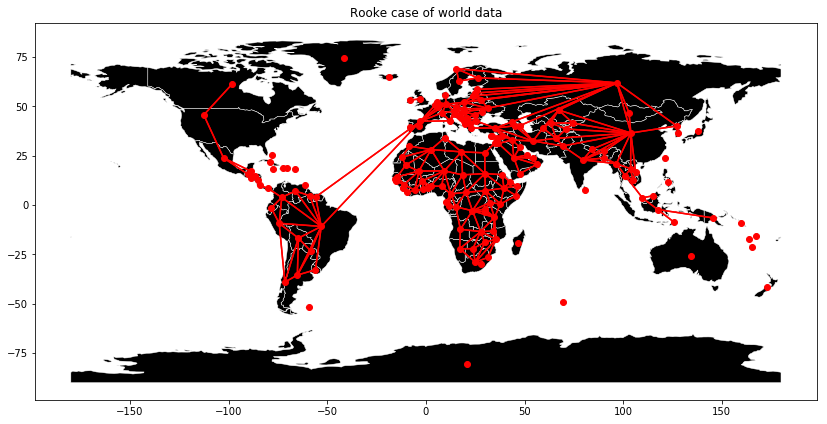

In [130]:
# show rook case with child-mortality-NoData
fig, ax = plt.subplots(figsize=(14, 14))
world_mortality.plot(color='k', ax=ax, edgecolor='w', linewidth=0.5)
w_rook_with_no_data.plot(world_mortality, ax=ax, color='red')
ax.set_title('Rooke case of world data')
plt.show()

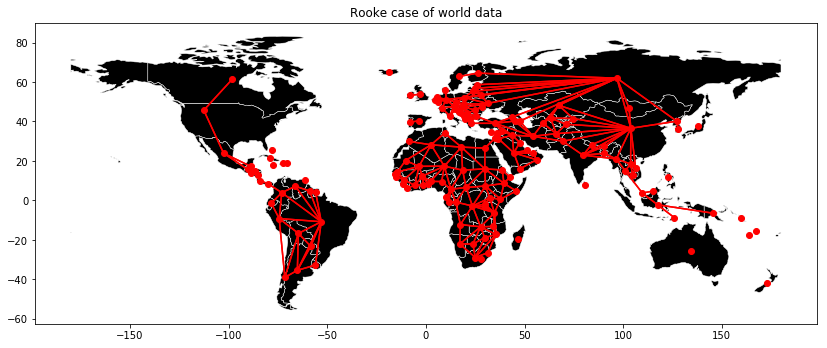

In [134]:
# show rook case without child-mortality-NoData
fig2, ax2 = plt.subplots(figsize=(14, 14))
dataForChildMortality.plot(color='k', ax=ax2, edgecolor='w', linewidth=0.5)
w_rook.plot(dataForChildMortality, ax=ax2, color='red')
ax2.set_title('Rooke case of world data')
plt.show()

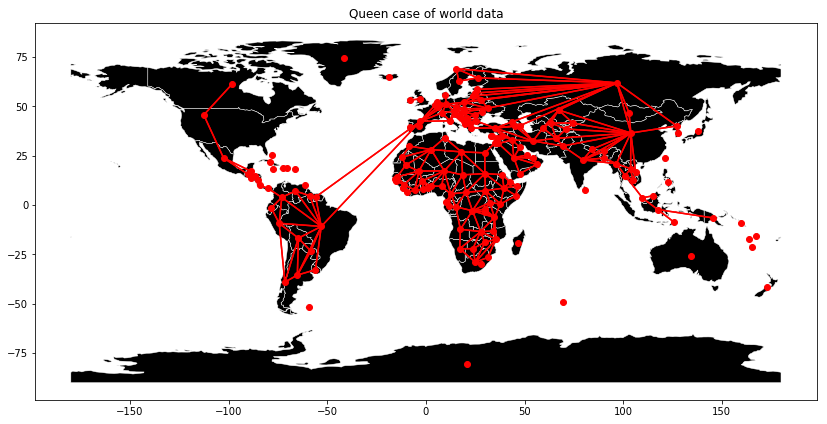

In [135]:
# show queen case with child-mortality-NoData
fig, ax = plt.subplots(figsize=(14, 14))
world_mortality.plot(color='k', ax=ax, edgecolor='w', linewidth=0.5)
w_queen_with_no_data.plot(world_mortality, ax=ax, color='red')
ax.set_title('Queen case of world data')
plt.show()

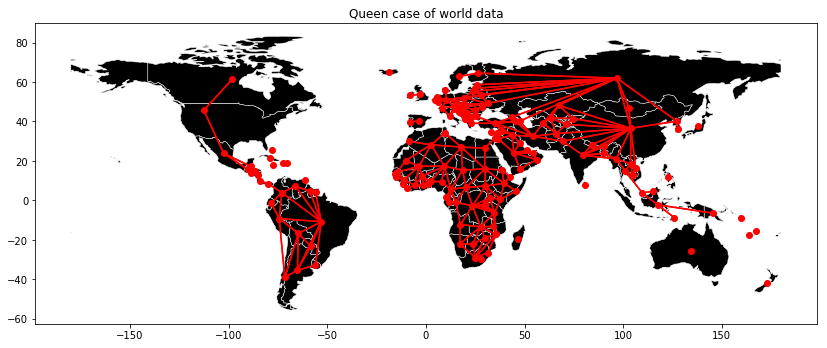

In [136]:
# show queen case without child-mortality-NoData
fig, ax = plt.subplots(figsize=(14, 14))
dataForChildMortality.plot(color='k', ax=ax, edgecolor='w', linewidth=0.5)
w_queen.plot(dataForChildMortality, ax=ax, color='red')
ax.set_title('Queen case of world data')
plt.show()

In [137]:
# moran I on child mortality including NoData and Rook case:
moran1 = esda.Moran(world_mortality['ChildMortality'], w_rook_with_no_data)
print("for all data, Moran's I using Rook weight is: ", moran1.I)
esda.Moran?
# moran I on child mortality excluding NoData but including Rook case:
moran2 = esda.Moran(dataForChildMortality['ChildMortality'], w_rook)
print("for all countries where child mortality is not NoData, Moran's I using Rook weight is: ", moran2.I)



('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 19, ' is an island (no neighbors)')
('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 46, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 78, ' is an island (no neighbors)')
('WARNING: ', 89, ' is an island (no neighbors)')
('WARNING: ', 134, ' is an island (no neighbors)')
('WARNING: ', 135, ' is an island (no neighbors)')
('WARNING: ', 136, ' is an island (no neighbors)')
('WARNING: ', 137, ' is an island (no neighbors)')
('WARNING: ', 138, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 144, ' is an island (no neighbors)')
('WARNING: ', 147, ' is an island (no neighbors)')
('WARNING: ', 155, ' is an island (no neighbors)')
('WARNING: ', 159, ' is an island (no neig

/Users/idarei/anaconda3/envs/Assignment/lib/python3.7/site-packages/pysal/explore/esda/moran.py:165: RuntimeWarning: invalid value encountered in greater_equal
  above = sim >= self.I


In [72]:
# moran I on child mortality including NoData and Queen case:
moran3 = esda.Moran(world_mortality['ChildMortality'], w_queen_with_no_data)
print("for all data, Moran's I using Queen weight is: ", moran3.I)

# moran I on child mortality excluding NoData but including Queen case:
moran4 = esda.Moran(dataForChildMortality['ChildMortality'], w_queen)
print("for all countries where child mortality is not NoData, Moran's I using Queen weight is: ", moran4.I)



for all data, Moran's I using Queen weight is:  nan
for all countries where child mortality is not NoData, Moran's I using Queen weight is:  0.7391687656288461


In [138]:
# One could argue that it might be better to give NoData options the mean value of child mortality 
# instead of removing whole countries.
# Also, some of the countries NoData values might be replaced by actual data by using other country abbreviation keys than only "ISO_A3".